In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
import sys
sys.path.insert(0, "/Users/vardhaanambati/Research Scripts")
from MyFunctions_python import *

### Load Dataset

In [19]:
#cervical_trauma_df = pd.read_excel('/Users/vardhaanambati/Library/CloudStorage/Box-Box/c1_c2_fractures/SFGH Trauma C1 C2 Fracture Mastersheet _011725.xlsx')
file = '/Users/vardhaanambati/Desktop/Research/Trauma/secure_ C1-C2 patient chart review/Datasets/C12_consec_multifriendly_dataset_Apr2025_Final.xlsx'
cervical_trauma_df = pd.read_excel(file, engine='openpyxl')

#mri_df = pd.read_excel('Datasets/SFGH Trauma C1 C2 Fracture MRI_Ligament Review_11112024.xlsx')

#cervical_trauma_df = pd.merge(cervical_trauma_df, mri_df[mri_columns], on="Med Rec # (MRN)")

In [20]:
print(len(cervical_trauma_df))

68


In [21]:
cervical_trauma_df

,Unnamed: 0,Med Rec # (MRN),Date of Arrival,Discharge Disposition,Date of Hospital Discharge,Age of Injury,Date of Injury,Sex,Mechanism of Injury,Neurodeficits,...,Comments,Expired during Admission,C1 Injury,C2 Injury,C1 and 2 Injury,Female,NonUnion,C2 Dens Anderson and D'Alonzo Type 1 or 3,C1 or C2 transverse foramen fracture,C1 Landells Type 1 or 2
0,28,1541490,2003-01-04 00:00:00,"DISCHARGED, SNF",2003-01-13 00:00:00,55,2003-01-04,F,MVA,0,...,NaN,0,1,1,1,1,NaN,0,0,0
1,29,450824,2003-01-14 00:00:00,"DISCHARGED, SNF",2003-01-30 00:00:00,62,2003-01-14,F,MVA,0,...,NaN,0,1,1,1,1,NaN,0,0,0
2,45,1771132,2010-08-15 00:00:00,HOME,2010-08-31 00:00:00,69,2010-08-15,M,MVA,0,...,NaN,0,1,1,1,0,NaN,1,0,1
3,51,1822280,2012-03-09 00:00:00,HOME,2012-03-16 00:00:00,85,2012-03-09,F,Fall from stairs,0,...,NaN,0,1,1,1,1,NaN,0,1,1
4,55,1843385,2013-01-01 00:00:00,HOSP TRANSFER,2013-01-03 00:00:00,71,2013-01-01,M,Ground level falls,0,...,NaN,0,1,1,1,0,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,132,200397550,2024-05-10 00:00:00,EXPIRED,2024-05-17 00:00:00,84,2024-05-10,M,Ground level falls,1,...,NaN,1,1,1,1,0,NaN,0,1,0
64,133,200399664,2024-05-19 00:00:00,"DISCHARGED, SNF",2024-05-23 00:00:00,93,2024-05-19,F,Ground level falls,1,...,NaN,0,1,1,1,1,1.0,1,1,0
65,284,1339937,2016-08-31 00:00:00,HOME,2016-09-07 00:00:00,72,2016-08-31,F,Fall from stairs,No,...,NaN,0,1,1,1,1,NaN,0,0,1
66,285,1927003,2016-09-11 00:12:00,"DISCHARGED, SNF",2016-09-21 17:12:00,85,2016-09-10,M,Fall from stairs,No,...,NaN,0,1,1,1,0,NaN,0,0,0


### Filter out Pts with Missing Fracture Data

In [22]:
columns_to_check = [
    "C1 Landells Type I",
    "C1 Landells Type 2",
    "C1 Landells Type 3",
    "C1 transverse foramen fracture",
    "C2 Dens Anderson and D'Alonzo Type 1",
    "C2 Dens Anderson and D'Alonzo Type 2",
    "C2 Dens Anderson and D'Alonzo Type 3",
    "C2 transverse foramen fracture",
    "C2 lateral mass fracture",
    "C2 Hangman's fracture",
    "Occipital Condyle Fracture"
]

# Drop rows where all specified columns are empty
cervical_trauma_df = cervical_trauma_df.dropna(subset=columns_to_check, how='all')

In [23]:
print(len(cervical_trauma_df))

68


### Variable Building

In [28]:
cervical_trauma_df['Expired during Admission'] = np.where(cervical_trauma_df['Outcome (home, skilled nursing, death)'].str.lower() == 'death', 1, 0)
C1_columns_to_check = [
    "C1 Landells Type I",
    "C1 Landells Type 2",
    "C1 Landells Type 3",
    "C1 transverse foramen fracture"
]

C2_columns_to_check = [
    "C2 Dens Anderson and D'Alonzo Type 1",
    "C2 Dens Anderson and D'Alonzo Type 2",
    "C2 Dens Anderson and D'Alonzo Type 3",
    "C2 transverse foramen fracture",
    "C2 lateral mass fracture",
    "C2 Hangman's fracture",
]


# Create 'C1 Injury' column
cervical_trauma_df['C1 Injury'] = cervical_trauma_df[C1_columns_to_check].apply(lambda row: 1 if (row == 1).any() else 0, axis=1)
# Create 'C2 Injury' column
cervical_trauma_df['C2 Injury'] = cervical_trauma_df[C2_columns_to_check].apply(lambda row: 1 if (row == 1).any() else 0, axis=1)

Combined_Injury = [
    "C1 Injury",
    "C2 Injury",
]
cervical_trauma_df['C1 and 2 Injury'] = ((cervical_trauma_df['C1 Injury'] == 1) & (cervical_trauma_df['C2 Injury'] == 1)).astype(int)

cervical_trauma_df['Female'] = np.where(cervical_trauma_df['Sex'].str.lower() == 'f', 1, 0)



cervical_trauma_df['Neurodeficits'] = np.where(cervical_trauma_df['Neurodeficits'] == 'No', 0, cervical_trauma_df['Neurodeficits'])


cervical_trauma_df['NonUnion'] = cervical_trauma_df['Had the fracture healed at follow up? (union vs. non-union)'].apply(
    lambda x: 1 if x == 'Nonunion' else (0 if x == 'Union' else np.nan)
)
cervical_trauma_df.loc[cervical_trauma_df['Expired during Admission'] == 1, 'NonUnion'] = np.nan

In [29]:
cervical_trauma_df['Neurodeficits'].value_counts()

0    35
1    33
Name: Neurodeficits, dtype: int64

In [31]:
cervical_trauma_df["C2 Dens Anderson and D'Alonzo Type 1 or 3"].value_counts()

0    50
1    18
Name: C2 Dens Anderson and D'Alonzo Type 1 or 3, dtype: int64

In [32]:
cervical_trauma_df["C2 Dens Anderson and D'Alonzo Type 1 or 3"] = ((cervical_trauma_df["C2 Dens Anderson and D'Alonzo Type 1"] == 1) | (cervical_trauma_df["C2 Dens Anderson and D'Alonzo Type 3"] == 1)).astype(int)


cervical_trauma_df["C1 or C2 transverse foramen fracture"] = ((cervical_trauma_df["C1 transverse foramen fracture"] == 1) | (cervical_trauma_df["C2 transverse foramen fracture"] == 1)).astype(int)


cervical_trauma_df["C1 Landells Type 1 or 2"] = ((cervical_trauma_df["C1 Landells Type I"] == 1) | (cervical_trauma_df["C1 Landells Type 2"] == 1)).astype(int)



In [33]:
count_both = ((cervical_trauma_df["C1 Landells Type I"] == 1) & (cervical_trauma_df["C1 Landells Type 2"] == 1)).sum()

# Count of rows where col1 is 1
count_col1 = (cervical_trauma_df["C1 Landells Type I"] == 1).sum()

# Count of rows where col2 is 1
count_col2 = (cervical_trauma_df["C1 Landells Type 2"] == 1).sum()

# Display the results
print(f"Count of 1s in both columns: {count_both}")
print(f"Count of 1s in col1: {count_col1}")
print(f"Count of 1s in col2: {count_col2}")

Count of 1s in both columns: 1
Count of 1s in col1: 28
Count of 1s in col2: 28


In [34]:
len(cervical_trauma_df)

68

In [35]:
len(cervical_trauma_df[cervical_trauma_df['Outcome (home, skilled nursing, death)'] == 'Death'])

17

In [68]:
cervical_trauma_df['What was the surgery (if applicable)'].value_counts()

C1-C2 PSF                                                                                       6
C1-C2 PSIF                                                                                      2
PR CERV C1-2 FUSN,POSTER TECH                                                                   2
C1-C2 fusion with transpedicular screws                                                         1
Screw insertion, odontoid C2                                                                    1
C2-C3 ACDF                                                                                      1
C6-T4 PSIF                                                                                      1
C1-C3 PSF                                                                                       1
C1-C6 PSIF, C2-C5 laminectomy                                                                   1
Anterior cervical approach for C2 odontoid screw placement                                      1
C3-T2 PSIF, C5-C7 la

In [36]:
survived_df = cervical_trauma_df[cervical_trauma_df['Outcome (home, skilled nursing, death)'] != 'Death']
len(survived_df)

51

In [37]:
survived_df['Dead'].value_counts()

1.0    9
Name: Dead, dtype: int64

In [63]:
9/51

0.17647058823529413

In [65]:
died_fu_df = survived_df[survived_df['Dead']==1]
len(died_fu_df[died_fu_df['Length of follow up from discharge'] < 365])
4/9

0.4444444444444444

In [64]:
print(f"Mean survival after discharge: {np.mean(survived_df[survived_df['Dead']==1]['Length of follow up from discharge'])/365}")
print(f"Min survival after discharge: {np.min(survived_df[survived_df['Dead']==1]['Length of follow up from discharge'])}")
print(f"Max survival after discharge: {np.max(survived_df[survived_df['Dead']==1]['Length of follow up from discharge'])/365}")

Mean survival after discharge: 2.422526636225266
Min survival after discharge: 30.0
Max survival after discharge: 7.186301369863013


### Study Variables 

In [42]:
Study_Vars = ['Age of Injury', 'Female', 
                    'HTN?', 'Afib?', 'HLD?', 'DM?',  'SUD/AUD?', 'Osteoporosis?', 'Dementia?',
                    'Mechanism of Injury',
                    'Injury Severity Score',
                    'Neurodeficits']
mri_columns = ["MRI", "Ligament Damage", "Anterior longitudinal", "Posterior longitudinal", "Transverse", "Right alar", "Left alar", "Tectorial", 
              "Anterior atlantoaxial", "Posterior atlantoaxial", "Anterior atlantoocipital", "Posterior atlantoocciptal", "Ligamentum flavum",
              "Apical", "Nuchal", "Supraspinous"]
Study_Vars.extend(mri_columns)

Study_Vars.extend(["Occipital Condyle Fracture",
                    "C1 Landells Type 1 or 2",
                    "C1 Landells Type 3", 
                    "C2 Dens Anderson and D'Alonzo Type 1 or 3",
                    "C2 Dens Anderson and D'Alonzo Type 2",
                    "C1 or C2 transverse foramen fracture",
                    "C2 lateral mass fracture",
                    "C2 Hangman's fracture",
                    'Surgery',
                    'Expired during Admission',
                    'NonUnion'])

continuous_vars = ['Age of Injury', 'Injury Severity Score']

### Cohort Building

In [43]:
cervical_trauma_df['Neurodeficits'].value_counts()

0    35
1    33
Name: Neurodeficits, dtype: int64

In [56]:
cervical_trauma_df = cervical_trauma_df[cervical_trauma_df['C1 and 2 Injury']==1]
cervical_trauma_df.to_csv('Datasets/C12_consec_multifriendly_dataset_Apr2025_Final.csv')
Name = "C12_CONSECUTIVE_Cases"
Fisher = True
print(len(cervical_trauma_df))

68


In [45]:
#cervical_trauma_df.to_excel('Datasets/C12_consec_confirmed_dataset_Jan2025.xlsx')

In [46]:
cervical_trauma_df['MRI'].value_counts()

1.0    44
0.0    20
Name: MRI, dtype: int64

### Build Tables

In [47]:
Tables = {}

#### Table 1

In [48]:
Tables['Study Cohort']= Table1_Study_Cohort_Describe(cervical_trauma_df, Study_Vars, continuous_vars)

#### Table 2: Death - FULL Cohort

In [49]:
independent_var = 'Expired during Admission'
Tables['Expired Inpatient; Full (Uni)']= Build_Uni_Comparison_Table(cervical_trauma_df, independent_var, Study_Vars, continuous_vars, Fisher)

The variable is binary (0 or 1). No dummy column created.
R code for multivariate: 
Expired.during.Admission ~ Female + HTN. + Injury.Severity.Score + Neurodeficits + Posterior.atlantoaxial + C2.Dens.Anderson.and.D.Alonzo.Type.1.or.3 + Surgery


#### Table 3: Surgery - FULL cohort

In [50]:
independent_var = 'Surgery'
Tables['Surgery Analysis (Uni)']= Build_Uni_Comparison_Table(cervical_trauma_df, independent_var, Study_Vars, continuous_vars, Fisher)

The variable is binary (0 or 1). No dummy column created.
R code for multivariate: 
Surgery ~ Female + DM. + Injury.Severity.Score + MRI + Posterior.longitudinal + Ligamentum.flavum + Apical + Supraspinous + C2.Dens.Anderson.and.D.Alonzo.Type.1.or.3 + C2.Dens.Anderson.and.D.Alonzo.Type.2 + Expired.during.Admission


#### Table 4: NonUnion - FULL cohort

In [51]:
union_df = cervical_trauma_df[cervical_trauma_df['Expired during Admission']!=1]
union_df = union_df[~union_df['NonUnion'].isna()]

independent_var = 'NonUnion'
Tables['NonUnion Analysis (Uni)']= Build_Uni_Comparison_Table(union_df, independent_var, Study_Vars, continuous_vars, Fisher)

The variable is binary (0 or 1). No dummy column created.
R code for multivariate: 
NonUnion ~ Age.of.Injury + Mechanism.of.Injury + Injury.Severity.Score + Anterior.longitudinal + C2.Dens.Anderson.and.D.Alonzo.Type.2 + C2.lateral.mass.fracture


In [62]:
union_df["C2 Hangman's fracture"].value_counts()

0    22
Name: C2 Hangman's fracture, dtype: int64

#### Table 5: Death - PSM Cohort

c12_consec_died_PSM_df = pd.read_csv('Datasets/c12_consec_died_PSM.csv')
independent_var = R_friendly('Expired during Admission')
Study_Vars_R = R_friendly(Study_Vars)
continuous_vars_R = R_friendly(continuous_vars)

Tables['Expired Inpatient; PSM (Uni)']= Build_Uni_Comparison_Table(c12_consec_died_PSM_df, independent_var, Study_Vars_R, continuous_vars_R, Fisher, output_Multi = False)

#### Table 5: Surgery - PSM Cohort

c12_consec_surg_PSM_df = pd.read_csv('Datasets/c12_consec_surg_PSM.csv')
independent_var = R_friendly('Surgery')

Tables['Surgery Analysis; PSM (Uni)']= Build_Uni_Comparison_Table(c12_consec_surg_PSM_df, independent_var, Study_Vars_R, continuous_vars_R, Fisher, output_Multi = False)

#### Table 6: Union - PSM Cohort

c12_consec_Nonunion_PSM_df = pd.read_csv('Datasets/c12_consec_Nonunion_PSM.csv')
independent_var = R_friendly('NonUnion')

Tables['NonUnion Analysis; PSM (Uni)']= Build_Uni_Comparison_Table(c12_consec_Nonunion_PSM_df, independent_var, Study_Vars_R, continuous_vars_R, Fisher, output_Multi = False)

### Export Univariate Tables

In [52]:
Export_Univariate_Tables_To_Excel(Tables, Name)

In [53]:
### Can Check before deleting yesterday's files
#compare_excel_files('C12_ALL_Cases_Multivariate_09_07_2024.xlsx', 'C12_All_Cases_Multivariate_09_08_2024.xlsx')

### ***** Run Multivariate in R

cervical_trauma_df.to_csv('C12_multifriendly_dataset.csv')

### Combine Uni and Multivariate

In [58]:
Combine_Uni_Multi_Excel_Files(Name, delete=True)

Deleted file: C12_CONSECUTIVE_Cases_Univariate_04_17_2025.xlsx
Deleted file: C12_CONSECUTIVE_Cases_Multivariate_04_17_2025.xlsx


## Fracture Correlation with One Another

In [22]:
fracture_types = columns_to_check


fracture_types2 = [
    "C1 Landells Type 1 or 2",
    "C1 Landells Type 3",
    "C2 Dens Anderson and D'Alonzo Type 1 or 3",
    "C2 Dens Anderson and D'Alonzo Type 2",
    "C1 or C2 transverse foramen fracture",
    "C2 lateral mass fracture",
    "C2 Hangman's fracture",
    "Occipital Condyle Fracture"
]


In [23]:
#import rpy2.robjects as ro
#from rpy2.robjects import numpy2ri

n = 1
for i in range(len(fracture_types)):
    fracture = fracture_types[i]
    for j in range(i + 1, len(fracture_types)):
        fracture2 = fracture_types[j]
        #if not (("C1" in fracture and "C1" in fracture2) or ("C2" in fracture and "C2" in fracture2)):
        x = cervical_trauma_df[fracture].astype(float)  # Independent variable
        y = cervical_trauma_df[fracture2].astype(float)  # Dependent variable

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        if p_value < 0.05:
            print(f"{n}: {fracture} ~ {fracture2}")
            print(f"Correlation coefficient: {r_value}")
            print(f"P-value: {p_value}")

            # Interpretation of the correlation coefficient
            if r_value > 0:
                print("Interpretation: The fractures tend to occur together.")
            elif r_value < 0:
                print("Interpretation: The fractures tend to occur in isolation.")
            else:
                print("Interpretation: There is no significant relationship between the fractures.")

            # Calculate and print the percentage for both fracture types
            count_01 = (cervical_trauma_df[fracture] == 0) & (cervical_trauma_df[fracture2] == 1)
            count_11 = (cervical_trauma_df[fracture] == 1) & (cervical_trauma_df[fracture2] == 1)

            percent_01 = str(round(count_01.sum() / (cervical_trauma_df[fracture] == 0).sum() * 100, 2))
            percent_11 = str(round(count_11.sum() / (cervical_trauma_df[fracture] == 1).sum() * 100, 2))

            print(f"Percentage for {fracture} = 0 and {fracture2} = 1: {percent_01}%")
            print(f"Percentage for {fracture} = 1 and {fracture2} = 1: {percent_11}%")
            print("")
                

1: C1 Landells Type I ~ C1 Landells Type 2
Correlation coefficient: -0.651874647857626
P-value: 3.057002958347155e-09
Interpretation: The fractures tend to occur in isolation.
Percentage for C1 Landells Type I = 0 and C1 Landells Type 2 = 1: 69.23%
Percentage for C1 Landells Type I = 1 and C1 Landells Type 2 = 1: 3.7%

1: C1 Landells Type I ~ Occipital Condyle Fracture
Correlation coefficient: -0.2631174057921088
P-value: 0.032801809741708814
Interpretation: The fractures tend to occur in isolation.
Percentage for C1 Landells Type I = 0 and Occipital Condyle Fracture = 1: 15.38%
Percentage for C1 Landells Type I = 1 and Occipital Condyle Fracture = 1: 0.0%

1: C1 Landells Type 2 ~ C1 Landells Type 3
Correlation coefficient: -0.31922063429064507
P-value: 0.008986987774744023
Interpretation: The fractures tend to occur in isolation.
Percentage for C1 Landells Type 2 = 0 and C1 Landells Type 3 = 1: 34.21%
Percentage for C1 Landells Type 2 = 1 and C1 Landells Type 3 = 1: 7.14%

1: C1 Lande

Results DataFrame:
                                      C1 Landells Type I  C1 Landells Type 2  \
C1 Landells Type I                                   NaN           -0.651875   
C1 Landells Type 2                             -0.651875                 NaN   
C1 Landells Type 3                                   NaN           -0.319221   
C1 transverse foramen fracture                       NaN                 NaN   
C2 Dens Anderson and D'Alonzo Type 1                 NaN                 NaN   
C2 Dens Anderson and D'Alonzo Type 2                 NaN            0.280687   
C2 Dens Anderson and D'Alonzo Type 3                 NaN                 NaN   
C2 transverse foramen fracture                       NaN                 NaN   
C2 lateral mass fracture                             NaN                 NaN   
C2 Hangman's fracture                                NaN                 NaN   
Occipital Condyle Fracture                     -0.263117                 NaN   

                    

Text(0.5, 1.0, 'Heatmap of Significant Fracture Relationships')

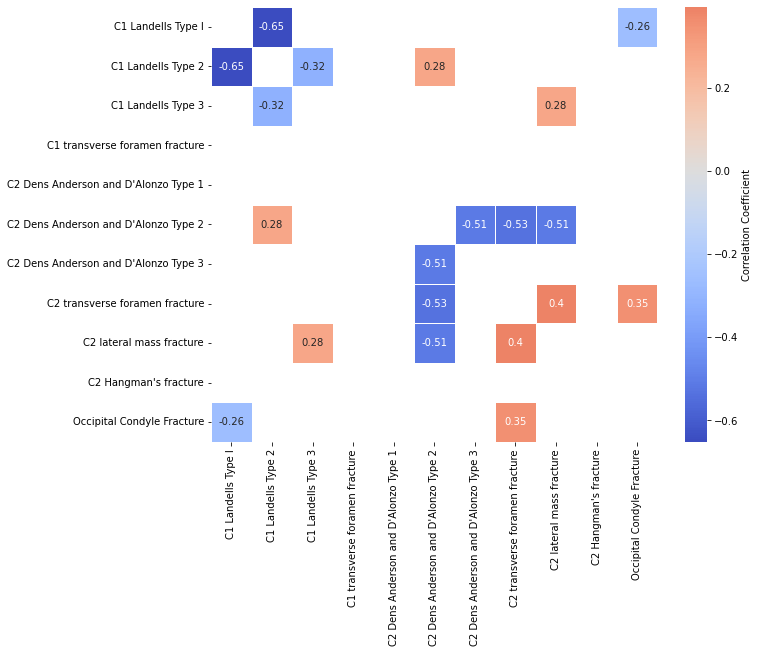

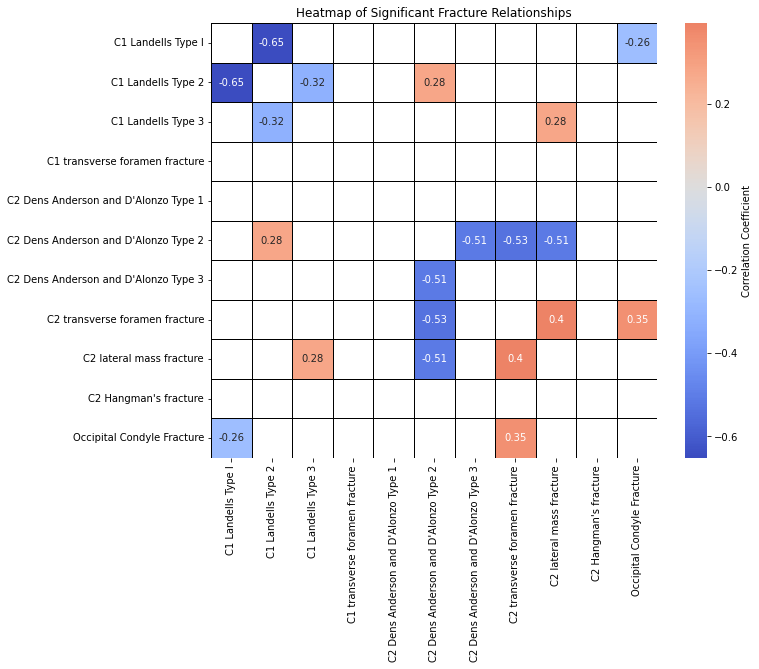

In [33]:
results_df = pd.DataFrame(index=fracture_types, columns=fracture_types)

for i in range(len(fracture_types)):
    fracture = fracture_types[i]
    for j in range(i + 1, len(fracture_types)):
        fracture2 = fracture_types[j]
        #if not (("C1" in fracture and "C1" in fracture2) or ("C2" in fracture and "C2" in fracture2)):
        x = cervical_trauma_df[fracture].astype(float)
        y = cervical_trauma_df[fracture2].astype(float)

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        if p_value < 0.05:  # Only consider significant results
            results_df.loc[fracture, fracture2] = r_value
            results_df.loc[fracture2, fracture] = r_value  # Mirror the value
        else:
            results_df.loc[fracture, fracture2] = np.nan  # Fill with NaN for non-significant
            results_df.loc[fracture2, fracture] = np.nan  # Mirror the NaN

results_df = results_df.apply(pd.to_numeric, errors='coerce')

print("Results DataFrame:")
print(results_df)
print("Data types:")
print(results_df.dtypes)


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results_df, annot=True, cmap='coolwarm', center=0, cbar_kws={"label": "Correlation Coefficient"},
            mask=results_df.isnull(), linewidths=0.5)



# Customize the heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(
    results_df, 
    annot=True, 
    cmap='coolwarm', 
    center=0, 
    cbar_kws={"label": "Correlation Coefficient"},
    mask=results_df.isnull(), 
    linewidths=0.5, 
    linecolor='black',
    square = False# Color of the grid lines
)
plt.title('Heatmap of Significant Fracture Relationships')

Calculating Pearson correlation for C1 Landells Type 1 or 2 and C1 Landells Type 3
-0.681746656753218 2.946608038602843e-10
Calculating Pearson correlation for C1 Landells Type 1 or 2 and C2 Dens Anderson and D'Alonzo Type 1 or 3
0.11226255234242725 0.3694836584075133
Calculating Pearson correlation for C1 Landells Type 1 or 2 and C2 Dens Anderson and D'Alonzo Type 2
0.09289506695219225 0.45816611159546433
Calculating Pearson correlation for C1 Landells Type 1 or 2 and C1 or C2 transverse foramen fracture
-0.09999999999999998 0.4243559820586625
Calculating Pearson correlation for C1 Landells Type 1 or 2 and C2 lateral mass fracture
-0.26040668824617663 0.03471094552417489
Calculating Pearson correlation for C1 Landells Type 1 or 2 and C2 Hangman's fracture
0.08333333333333333 0.5059056600840006
Calculating Pearson correlation for C1 Landells Type 1 or 2 and Occipital Condyle Fracture
-0.3975231959999626 0.0009493349463079046
Calculating Pearson correlation for C1 Landells Type 3 and C2

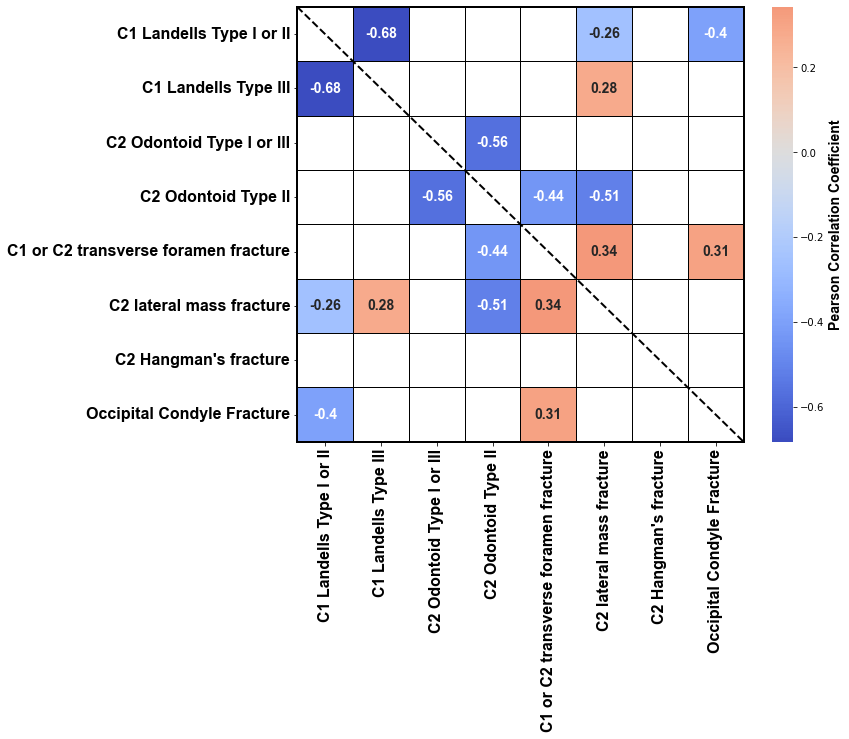

In [75]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Define the replacement dictionary
replacement_dict = {
    "C1 Landells Type 1 or 2": "C1 Landells Type I or II",
    "C1 Landells Type 3": "C1 Landells Type III",
    "C2 Dens Anderson and D'Alonzo Type 1 or 3": "C2 Odontoid Type I or III",
    "C2 Dens Anderson and D'Alonzo Type 2": "C2 Odontoid Type II"
}

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(index=fracture_types2, columns=fracture_types2)

# Loop through all pairs of fractures to calculate Pearson's correlation and check for significance
for i in range(len(fracture_types2)):
    fracture = fracture_types2[i]
    for j in range(i+1, len(fracture_types2)):
        fracture2 = fracture_types2[j]
        
        print(f'Calculating Pearson correlation for {fracture} and {fracture2}')
        
        # Convert data to numeric, coercing errors to NaN (in case there are non-numeric values)
        x = pd.to_numeric(cervical_trauma_df[fracture], errors='coerce')
        y = pd.to_numeric(cervical_trauma_df[fracture2], errors='coerce')
        
        # Calculate Pearson correlation coefficient and p-value
        r_value, p_value = stats.pearsonr(x, y)
        print(r_value, p_value)
        # Store the r-value (even for non-significant correlations)
        if p_value < 0.05:  # Only consider significant results
            results_df.loc[fracture, fracture2] = r_value
            results_df.loc[fracture2, fracture] = r_value  # Mirror the value
        else:
            results_df.loc[fracture, fracture2] = np.nan  # Fill with NaN for non-significant
            results_df.loc[fracture2, fracture] = np.nan  # Mirror the value

# Ensure the results dataframe is numeric and coercing errors to NaN
results_df = results_df.apply(pd.to_numeric, errors='coerce')

# Display the results dataframe
print("Results DataFrame:")
print(results_df)

# Set font properties for plot
font_properties = {'family': 'Arial', 'weight': 'bold'}

# Create an annotation matrix where only significant values are shown
annot_matrix = results_df.copy()

# Replace non-significant values with None for annotation (i.e., leave them blank)
for i in range(len(fracture_types2)):
    for j in range(i+1, len(fracture_types2)):
        if i != j:  # Exclude diagonal
            # Calculate p-value for the correlation
            x = pd.to_numeric(cervical_trauma_df[fracture_types2[i]], errors='coerce')
            y = pd.to_numeric(cervical_trauma_df[fracture_types2[j]], errors='coerce')
            _, p_value = stats.pearsonr(x, y)
            # If the p-value is >= 0.05, set the annotation to None for blank
            if p_value >= 0.05:
                annot_matrix.iloc[i, j] = ""  # Set non-significant values to blank

# Create a heatmap of the significant Pearson correlation coefficients
plt.figure(figsize=(10, 8))

# Replace fracture labels according to the replacement dictionary
updated_labels = [replacement_dict.get(label, label) for label in fracture_types2]

# Plot the heatmap
heatmap = sns.heatmap(
    results_df, 
    annot=annot_matrix,  # Only annotate significant values (non-significant will be "")
    cmap='coolwarm', 
    center=0, 
    cbar_kws={  # Colorbar properties without fontsize
        "label": "Pearson Correlation Coefficient",  # Label text for colorbar
    },
    annot_kws={"size": 14, "weight": 'bold', 'family': 'Arial'},  # Annotation font size, weight, and family
    xticklabels=updated_labels,  # Use updated fracture labels for x-axis
    yticklabels=updated_labels,  # Use updated fracture labels for y-axis
    square=False,
    linewidths=0.5, 
    linecolor='black'
)

# Add a dashed line from the top-left corner to the bottom-right corner
plt.plot([0, len(fracture_types2)], [0, len(fracture_types2)], color='black', linestyle='--', linewidth=2)

# Add a border around the heatmap (making sure all spines are visible and styled correctly)
ax = plt.gca()  # Get current axes
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)  # Set the thickness of the border
    spine.set_edgecolor('black')  # Set the color of the border

# Adjust font sizes for the title and axis labels
#plt.title('Heatmap of Significant Pearson Correlation Between Fractures', fontsize=16, **font_properties)
#plt.xlabel('Fracture Type', fontsize=16, **font_properties)
#plt.ylabel('Fracture Type', fontsize=16, **font_properties)

# Update tick label font properties
plt.xticks(fontsize=16, fontweight='bold', family='Arial')
plt.yticks(fontsize=16, fontweight='bold', family='Arial')

# After creating the heatmap, update colorbar label font properties
cbar = heatmap.collections[0].colorbar
cbar.set_label("Pearson Correlation Coefficient", fontsize=14, fontweight='bold', family='Arial')

# Show the plot
plt.show()


In [76]:
pd.crosstab(cervical_trauma_df["C2 Dens Anderson and D'Alonzo Type 2"], cervical_trauma_df["C1 Landells Type 1 or 2"])

C1 Landells Type 1 or 2,0,1
C2 Dens Anderson and D'Alonzo Type 2,,
0.0,7,25
1.0,5,29


In [74]:
# Filter the DataFrame where 'C2 Dens Anderson and D\'Alonzo Type 2' is 1
filtered_df = cervical_trauma_df[cervical_trauma_df["C2 Dens Anderson and D'Alonzo Type 2"] == 1]

# List of fracture types to check
other_fracture_types2 = [
    "C1 Landells Type 1 or 2",
    "C1 Landells Type 3",
    "C2 Dens Anderson and D'Alonzo Type 1 or 3",
    "C1 or C2 transverse foramen fracture",
    "C2 lateral mass fracture",
    "C2 Hangman's fracture",
    "Occipital Condyle Fracture"
]

# Get value counts for each fracture type in the filtered DataFrame
value_counts = filtered_df[fracture_types2].apply(pd.Series.value_counts, axis=0)

# Display the result
print(value_counts)


     C1 Landells Type 1 or 2  C1 Landells Type 3  \
0.0                        5                  29   
1.0                       29                   5   

     C2 Dens Anderson and D'Alonzo Type 1 or 3  \
0.0                                         33   
1.0                                          1   

     C2 Dens Anderson and D'Alonzo Type 2  \
0.0                                   NaN   
1.0                                  34.0   

     C1 or C2 transverse foramen fracture  C2 lateral mass fracture  \
0.0                                    32                      34.0   
1.0                                     2                       NaN   

     C2 Hangman's fracture  Occipital Condyle Fracture  
0.0                     33                          33  
1.0                      1                           1  
